In [11]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import json
from itertools import islice
import itertools
import random

import collections
%matplotlib inline

In [12]:
# All params
Q_list = [0.15]
W_list = [0.15]
D_list = [0.6]
T_list = [0.00001, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
wb_list = [5.0]
decay_list = [18.0]
seed_list = list(np.arange(0, 25))
n_workers = 35

param_sets = list(itertools.product(Q_list, W_list, D_list, T_list, wb_list, decay_list))

### Fiji script to grab concentration data

In [3]:
base_exp_dir = "experiments/forConcentration_Q0.15_W0.15_D0.6_T0.0250_wb5.0_decay18.0_seed24"

In [4]:
bee_path = os.path.join(base_exp_dir, "bee_hist.h5")

In [5]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [6]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    concentration = bee_data['concentration'][idxs]
    threshold_met = bee_data['threshold_met'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "concentration": concentration, 
                     "threshold_met" : threshold_met}

In [7]:
sim_time = len(bees[0]['state'])
time_array = np.arange(0, sim_time)
time_groups = [500, 500, 1000, 2000, 2000, 2000]  # intervals of above list
it = iter(time_array)
sliced = [list(islice(it, 0, i)) for i in time_groups]

In [8]:
total_concentration_dict = {}
for bee_i, bee in enumerate(bees):
    single_bee = bees[bee_i]
    single_bee_state = single_bee['state']
    single_bee_concentration = single_bee['concentration']
    
    timegroup_dict = {}
    for g_i, g in enumerate(sliced):
        # Filter scenting bees
        state_mask = single_bee_state[g] == 1
        
        # Accumulate the concentrations - this length will vary
        scenting_concentrations = single_bee_concentration[g][state_mask]
        
        # Make dictionary of concentrations for a single bee
        timegroup_dict[f'timegroup_{g_i}'] = list(scenting_concentrations)
     
    total_concentration_dict[f'bee_{bee_i}'] = timegroup_dict

In [9]:
len(total_concentration_dict['bee_0']['timegroup_0'])

58

In [10]:
# Write json for 25 trials 
with open(f'concentration_data_{n_workers}.json', 'w') as fp:
    json.dump(test_dic, fp)

NameError: name 'test_dic' is not defined

In [ ]:
# # Mock multiple trials
# total = {"A": total_concentration_dict,
#         "B": total_concentration_dict.copy()}

### Post-fiji plotting

In [176]:
def read_data(wb, density):
    filename = f"worker_concentration/concentration_data/concentration_data_wb{wb:0.1f}_n{density}.json"

    with open(filename) as f:
        concentration_data = json.load(f)

    return concentration_data


In [177]:
def concat_lists(wb, optimal_T, random_trial):
    
    # Read in data for a given trial
    total = concentration_data[f'Q0.15_W0.15_D0.6_T{optimal_T:0.4f}_wb{wb:0.1f}_decay18.0'][str(random_trial)]

    # Concatenate lists across all bees
    all_bees = {}
    for bee_i, bee_lists in total.items():
        for list_key, list_vals in bee_lists.items():
            if list_key in all_bees:
                all_bees[list_key] += list_vals
            else:
                all_bees[list_key] = list_vals
    
    return all_bees

In [178]:
def merge_order(all_bees):
    # Can customize merging method later
    all_bees_merged = {
    "timegroup_0": all_bees['timegroup_0'], # 0-500
    "timegroup_1": all_bees['timegroup_1'], # 500-1000
    "timegroup_2": all_bees['timegroup_2'] + all_bees['timegroup_3'], # 1000-4000
    "timegroup_3": all_bees['timegroup_4'] + all_bees['timegroup_5'], # 4000-8000
    }
    
    all_bees_ordered = collections.OrderedDict(reversed(list(all_bees_merged.items())))

    return all_bees_ordered

In [185]:
def plot_hist(ax, time_array, all_bees_ordered, n, wb, density, optimalT):
    for time_i, (timegroup, concentrations) in enumerate(all_bees_ordered.items()):
        concentrations_array = np.array(concentrations)
        x = np.mean(concentrations_array[:(len(concentrations_array)//n)*n].reshape(-1,n), axis=1)

        sns.distplot(x, kde=False, bins=100, 
                     hist_kws=dict(alpha=0.8, edgecolor="w", linewidth=0.3),
                     label=f"{time_array[time_i+1]} - {time_array[time_i]}", ax=ax)
        sns.despine()

#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(title="Time group", handles=handles[::-1])
#     plt.xlabel('Concentration')
#     plt.ylabel('Count')
#     plt.title(f'Concentration distribution \nwb={wb}, density={density}, optimal threshold={optimalT}')

In [183]:
sns.set(style="ticks")

In [180]:
density_dict = {
    "35" : [0.001, 0.01],  # Optimal T for wb=0 and wb=5
    "70" : [0.001, 0.025],
    "140": [0.025, 0.1]
}

In [193]:
new_data = {}

# Pick a random trial
# random.seed(1)
random_trial = random.choice(seed_list)

for density_i, density in enumerate(density_dict):
    new_data[density] = {}
    for T_i, optimal_T in enumerate(density_dict[density]):
        
        sys.stdout.write(f"\rDensity {density_i} -- Optimal {T_i}")
        sys.stdout.flush()
        
        # Read data
        wb = T_i * 5        
        try:
            concentration_data = read_data(wb, density)
        except:
            print(density)
            
        # Concat bees for same time groups
        all_bees = concat_lists(wb, optimal_T, random_trial)

        # Ordered data dict
        all_bees_ordered = merge_order(all_bees)
        
        new_data[density][optimal_T] = all_bees_ordered

Density 2 -- Optimal 1

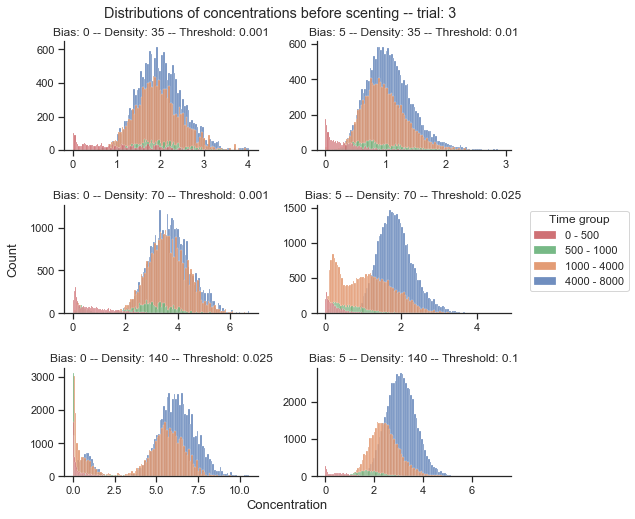

In [194]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

n = 1
time_array = [0, 500, 1000, 4000, 8000]
time_array = list(time_array[::-1])

biases = [0, 5] * 3

for i, (data_key, data_vals) in enumerate(new_data.items()):
    for j, (val_key, data_val) in enumerate(data_vals.items()):
        
        # Plot histogram        
        ax = axes[i][j]
        plot_hist(ax, time_array, data_val, n, wb, density, optimal_T)
        ax.set_title(f"Bias: {biases[j]} -- Density: {data_key} -- Threshold: {val_key}")

# Super title & legend
plt.suptitle(f'Distributions of concentrations before scenting -- trial: {random_trial}', x=0.5, y=0.94)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title="Time group", handles=handles[::-1], loc=(1.1, 1.7))

# Add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# Hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Concentration", size=13)
plt.ylabel("Count", labelpad=20, size=13)

plt.savefig(f'worker_concentration/figures/Concentration_Distribution_Trial{random_trial}.png', bbox_inches='tight')


In [54]:
# wb = 0
# density = 35
# wb0_optimalT = density_dict[f'{density}'][0]

# # Read data
# concentration_data = read_data(wb, density)

# # Concat bees for same time groups
# all_bees = concat_lists(wb, wb0_optimalT)

# # Ordered data dict
# all_bees_ordered = merge_order(all_bees)

# # Plot histogram
# # time = [0, 500, 1000, 2000, 4000, 6000, 8000]
# time_array = [0, 500, 1000, 4000, 8000]
# time_array = time[::-1]
# n = 1 # For average every nth element if needed
# plot_hist(time_array, all_bees_ordered, n, wb, density, wb0_optimalT)

In [ ]:
# random.seed(3)
# random_trial = random.choice(seed_list)
# random_trial

In [ ]:
# total = concentration_data[f'Q0.15_W0.15_D0.6_T{wb0_optimalT:0.4f}_wb{wb:0.1f}_decay18.0'][str(random_trial)]
# concentration_data['Q0.15_W0.15_D0.6_T0.0000_wb0.0_decay18.0'].keys()

In [ ]:
# total.keys()

In [ ]:
# # Concatenate lists across all bees
# all_bees = {}
# for bee_i, bee_lists in total.items():
#     for list_key, list_vals in bee_lists.items():
#         if list_key in all_bees:
#             all_bees[list_key] += list_vals
#         else:
#             all_bees[list_key] = list_vals
            
# len(all_bees['timegroup_5'])

In [ ]:
# all_bees_merged = {
#     "timegroup_0": all_bees['timegroup_0'], # 0-500
#     "timegroup_1": all_bees['timegroup_1'], # 500-1000
#     "timegroup_2": all_bees['timegroup_2'] + all_bees['timegroup_3'], # 1000-4000
#     "timegroup_3": all_bees['timegroup_4'] + all_bees['timegroup_5'], # 4000-8000
# }

In [ ]:
# all_bees_ordered = collections.OrderedDict(reversed(list(all_bees_merged.items())))
# all_bees_ordered.keys()

In [ ]:
# # time = [0, 500, 1000, 2000, 4000, 6000, 8000]
# time = [0, 500, 1000, 4000, 8000]
# time = time[::-1]

# n = 1
# for time_i, (timegroup, concentrations) in enumerate(all_bees_ordered.items()):
#     concentrations_array = np.array(concentrations)
#     x = np.mean(concentrations_array[:(len(concentrations_array)//n)*n].reshape(-1,n), axis=1)

#     sns.distplot(x, kde=False, bins=100, 
#                  hist_kws=dict(alpha=0.5, edgecolor="w", linewidth=0.3),
#                  label=f"{time[time_i+1]} - {time[time_i]}")
#     sns.despine()

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(title="Time group", handles=handles[::-1])
# plt.xlabel('Concentration')
# plt.ylabel('Count')
# plt.title(f'Concentration distribution - wb={wb}, density={density}, optimal threshold={wb0_optimalT}')

### Need to check 

In [ ]:
all_bees_all_trials = []

# Loop over all trials/seeds and accumulate concentrations
for t_key, t_val in total.items():
    
    # Loop over bees in an experiment (1 trial/seed)
    # Concatenate lists across all bees
    all_bees = {}
    for bee_i, bee_lists in total_concentration_dict.items():
        for list_key, list_vals in bee_lists.items():
            if list_key in all_bees:
                all_bees[list_key] += list_vals
            else:
                all_bees[list_key] = list_vals

    all_bees_all_trials.append(all_bees)

In [ ]:
len(list_vals)

In [ ]:
# Concatentate lists across all trials
all_trials = {}
for trial in all_bees_all_trials:
    for trial_i, trial_lists in total_concentration_dict.items():
        for list_key, list_vals in trial_lists.items():
            if list_key in all_trials:
                all_trials[list_key] += list_vals
            else:
                all_trials[list_key] = list_vals

In [ ]:
all_trials.keys()

In [ ]:
all_trials_merged = {
    "timegroup_0": all_trials['timegroup_0'], # 0-500
    "timegroup_1": all_trials['timegroup_1'], # 500-1000
    "timegroup_2": all_trials['timegroup_2'] + all_trials['timegroup_3'], # 1000-4000
    "timegroup_3": all_trials['timegroup_4'] + all_trials['timegroup_5'], # 4000-8000
}

In [ ]:
all_trials_ordered = collections.OrderedDict(reversed(list(all_trials_merged.items())))
all_trials_ordered.keys()

In [ ]:
# time = [0, 500, 1000, 2000, 4000, 6000, 8000]
time = [0, 500, 1000, 4000, 8000]
time = time[::-1]

In [ ]:
n = 2
for time_i, (timegroup, concentrations) in enumerate(all_trials_ordered.items()):
    concentrations_array = np.array(concentrations)
    x = np.mean(concentrations_array[:(len(concentrations_array)//n)*n].reshape(-1,n), axis=1)

    sns.distplot(x, kde=False, bins=100, 
                 hist_kws=dict(alpha=0.5, edgecolor="w", linewidth=0.3),
                 label=f"{time[time_i+1]} - {time[time_i]}")
    sns.despine()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title="Time group", handles=handles[::-1])
plt.xlabel('Concentration')
plt.ylabel('Count')
plt.title(f'Concentration distribution - wb={wb}, density={density}, optimal threshold={wb0_optimalT}')